# Solving Simple Two-Country Model with CBDC 

## Darren Chang

## Section 2.2

This file is to solve the basic model described in section 2.1 of *Central Bank Digital Currency in Open Economies*. The model is a CIA open economy RBC model in which the home economy implements CBDC. The home economy is modeled as a small economy while the foreign economy is a large open economy. This notebook implements a model with CBDC and bonds.

In [1]:
## imports
import numpy as np
import pandas as pd
import linearsolve as ls
from scipy.optimize import root,fsolve,broyden1,broyden2
import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline

In [423]:
# set parameters
A = 1
alpha = 0.32
delta = 0.1
sigma = 2
mu = 0.03 # interest = mu, rate of money growth
beta = 0.971 # (1+pi)/(1+rstar)
bbar = 0.7442 # debt

## cbdc parameters
# eta = 1.05 # Transaction efficiency for cash
theta1 = 2 # level parameter for transaction cost fxn
gamma = 2 # transaction cost for consumption goods

theta2 = 0.01 # calibrated spread
zeta = 1.75 #Transaction efficiency for CBDC

omega = 1.455 # Frisch elasticity from Mendoza 1991
phi = 0.028 # capital adjustment cost
psi1 = 0.000742 # debt elasticity of interest rate
rho = 0.42 # persistence of TFP shock
etat = 0.0129 # standard deviation of innovation to TFP shock

In [449]:
# solve for deterministic steady state
# pi = 0.01
pi_ss = mu
rstar_ss = (1+pi_ss)/beta-1
rd_ss = rstar_ss-theta2
kappa_ss = ((1/beta-1+delta)/alpha)**(1/(alpha-1))
n_ss = ((1-alpha)*kappa_ss**alpha)**(1/(omega-1))
k_ss = kappa_ss*n_ss
r_ss = rstar_ss
# kfu = k_ss
y_ss = A*kappa_ss**alpha*n_ss
I_ss = delta*k_ss

def calc_c(c):
    return c*pi_ss-c*(rd_ss-pi_ss)/(1+pi_ss)+theta1*c**gamma*(c/(1+pi_ss))**zeta-(bbar*(rstar_ss-pi_ss)/(1+pi_ss)-kappa_ss**alpha*n_ss-delta*k_ss)
                                                      
c_ss = root(calc_c, 0.5, method = 'lm')['x'][0]
d_ss = c_ss*(1+pi_ss)
la_ss = (c_ss-n_ss**omega/omega)**(-sigma)/(1+theta1*gamma*(c_ss**(gamma-1))/d_ss**zeta) # MU of wealth

C:\Users\darre\anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in power
  from ipykernel import kernelapp as app


In [450]:
# define equilibrium equations
def equilibrium_equations(variables_forward,variables_current,parameters):
    
    # Parameters 
    p = parameters
    
    # Variables
    fwd = variables_forward
    cur = variables_current
    
    # MU of wealth
    e1 = (cur.c-cur.n**p.omega/p.omega)**(-p.sigma)/(1+p.theta1*p.gamma*cur.c**(p.gamma-1)/cur.d**p.zeta) - cur.la

    # Evolution of debt
    e2 = -fwd.b+(1+cur.r)*cur.b/(1+cur.pi)+cur.c+cur.I+p.phi/2*(fwd.k-cur.k)**2-cur.y-fwd.d+(1+cur.rd)*cur.d/(1+cur.pi)+p.theta1*cur.c**p.gamma/(cur.d**p.zeta) # cur.pi
    # e1 = -fwd.b+(1+r)*cur.b/(1+p.pi)+cur.c+cur.I+p.phi/2*(fwd.k-cur.k)**2-cur.y # cur.pi
    
    # output
    e3 = -cur.y+A*cur.k**p.alpha*cur.n**(1-p.alpha)

    # FOC w.r.t. n
    e4 = -cur.n**(p.omega-1)+(1-p.alpha)*cur.A*(cur.k/cur.n)**p.alpha

    # FOC w.r.t. bonds
    e5 = -cur.la + p.beta*(1+cur.r)/(1+fwd.pi)*fwd.la # fwd.pi
    # e5 = -cur.la + p.beta*(1+r_ss)/(1+p.pi)*fwd.la # fwd.pi

    # FOC w.r.t. capital
    e6 = -cur.la*(1+p.phi*(fwd.k-cur.k))+p.beta*fwd.la*(1-p.delta+p.alpha*cur.A*(fwd.k/fwd.n)**(p.alpha-1)+p.phi*(fwd.kfu-cur.k))

    # Country premium
    e7 = -fwd.r+rstar_ss+p.psi1*(np.exp(fwd.b-bbar)-1)

    # Investment
    e8 = -cur.I+fwd.k-(1-p.delta)*cur.k

    # Evolution of TFP
    e9 = -fwd.A + p.rho*(cur.A)

    # make kfu=kp
    e10 = -cur.kfu+fwd.k
    
    # foc for d
    e11 = -cur.la+p.beta*fwd.la*((1+cur.rd)/(1+fwd.pi)-p.zeta*p.theta1*(fwd.c**p.gamma)*(cur.d**(-p.zeta-1)))
    
    # definition of rd
    e12 = -fwd.rd+cur.r-p.theta2
    
    # money supply
    e13 = -fwd.d + (1+p.mu)/(1+cur.pi)*cur.d
    
    return np.array([
        e1,
        e2,
        e3,
        e4,
        e5,
        e6,
        e7,
        e8,
        e9,
        e10,
        e11,
        e12,
        e13
    ])

In [451]:
parameter_vals = [alpha, delta, sigma, beta, bbar, theta1, gamma, zeta, theta2, omega, phi, psi1, rho, etat, mu] 
parameter_names = ['alpha','delta','sigma','beta','bbar','theta1','gamma','zeta','theta2','omega','phi','psi1','rho','etat','mu']
parameters = pd.Series(parameter_vals, index = parameter_names)

In [452]:
model = ls.model(equations = equilibrium_equations,
                 n_states=5,
                 # var_names=['A', 'la', 'c', 'k', 'kfu', 'h', 'n', 'b', 'y', 'I', 'tb', 'tby', 'ca', 'cay', 'r', 'tau'],
                 var_names=['A', 'la', 'c', 'k', 'kfu', 'd', 'rd', 'n', 'b', 'y', 'I', 'r', 'pi'],
                 shock_names= ['ea'],
                 parameters = parameters)

In [453]:
ss = [1, la_ss, c_ss, k_ss, k_ss, d_ss, rd_ss, n_ss, bbar, y_ss, I_ss, r_ss, pi_ss] # tau_ss

In [454]:
model.set_ss(ss)

In [455]:
print(model.ss)

A      1.000000
la     0.000052
c      0.000006
k      4.101302
kfu    4.101302
d      0.000006
rd     0.050762
n      1.088829
b      0.744200
y      1.664438
I      0.410130
r      0.060762
pi     0.030000
dtype: float64


In [456]:
# import scipy.linalg as la
# s,t,alpha,beta,q,z = la.ordqz(A=model.a,B=model.b,sort='ouc')
# z11 = z[0:4,0:4]
# z11
# np.linalg.matrix_rank(z11)

In [457]:
model.approximate_and_solve(log_linear = True)
model.impulse(T=15,t0=0,shocks=[-0.01],percent=True, diff = True)

SystemExit: Invertibility condition violated.

In [421]:
model.irs['ea'].head(10)

,ea,A,la,c,k,kfu,d,rd,n,b,y,I,r,pi
0,-1.0,-1.000000,0.000000,0.000000,0.000000,0.000000,-1735.490287,1.985847e+05,-1.290323,-10601.877249,-0.877419,-1.965570e-10,52539.126778,4.870353e+06
1,0.0,-0.420000,-57.480207,79237.545883,37024.200985,1116.258354,14415.135599,-1.491062e+06,15286.870084,117570.399953,22242.815972,-3.220552e+05,9317.246572,4.190720e+06
2,0.0,-0.176400,-104.479235,31323.579017,14490.932975,943.407434,5128.260432,-5.190470e+05,5983.125357,41205.284041,8705.623795,-1.209843e+05,7836.379384,3.200065e+06
3,0.0,-0.074088,-86.279793,27730.617459,12806.314066,796.470966,4547.248559,-4.605399e+05,5287.672791,36583.137229,7693.637999,-1.072921e+05,6617.033635,2.712058e+06
4,0.0,-0.031117,-72.900883,23366.640648,10791.694495,672.427438,3831.318791,-3.880266e+05,4455.885318,30822.056872,6483.344255,-9.040098e+04,5586.997417,2.289331e+06
5,0.0,-0.013069,-61.541720,19729.103971,9111.700797,567.706100,3234.877718,-3.276231e+05,3762.233788,26023.961543,5474.063231,-7.632825e+04,4717.113547,1.932819e+06
6,0.0,-0.005489,-51.956207,16656.529793,7692.661607,479.295131,2731.074718,-2.765997e+05,3176.317710,21970.995728,4621.547757,-6.444100e+04,3982.590007,1.631816e+06
7,0.0,-0.002305,-43.864319,14062.556309,6494.659056,404.653341,2305.752232,-2.335240e+05,2681.662700,18549.368237,3901.821534,-5.440540e+04,3362.409429,1.377691e+06
8,0.0,-0.000968,-37.032990,11872.563513,5483.231418,341.635955,1946.670820,-1.971568e+05,2264.042691,15660.627731,3294.183084,-4.593272e+04,2838.791294,1.163141e+06
9,0.0,-0.000407,-31.265679,10023.629380,4629.318590,288.432488,1643.511873,-1.664532e+05,1911.460054,13221.769254,2781.174786,-3.877954e+04,2396.708832,9.820036e+05


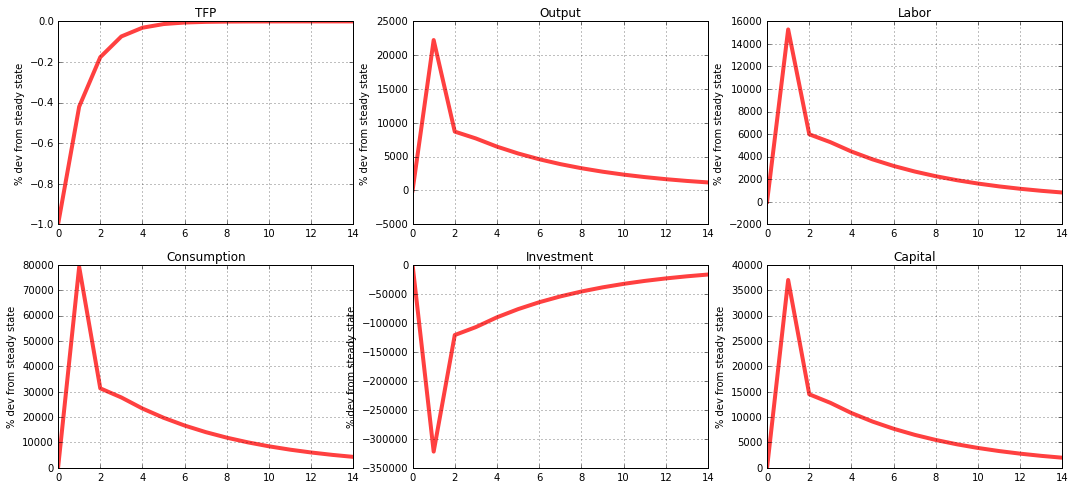

In [422]:
fig = plt.figure(figsize=(18,8))

# TFP
ax = fig.add_subplot(2,3,1)
ax.plot(model.irs['ea']['A'],'r',lw=4,alpha=0.75)
ax.set_title('TFP')
ax.set_ylabel('% dev from steady state')
# ax.set_ylim([-1.5, 0.5])
ax.grid()

# output
ax = fig.add_subplot(2,3,2)
ax.plot(model.irs['ea']['y'],'r',lw=4,alpha=0.75)
ax.set_title('Output')
ax.set_ylabel('% dev from steady state')
# ax.set_ylim([-2.6,0.5])
ax.grid()

# labor
ax = fig.add_subplot(2,3,3)
ax.plot(model.irs['ea']['n'],'r',lw=4,alpha=0.75)
ax.set_title('Labor')
ax.set_ylabel('% dev from steady state')
# ax.set_ylim([-1.6,0.5])
ax.grid()

# consumption
ax = fig.add_subplot(2,3,4)
ax.plot(model.irs['ea']['c'],'r',lw=4,alpha=0.75)
ax.set_title('Consumption')
ax.set_ylabel('% dev from steady state')
# ax.set_ylim([-4.2,0.5])
ax.grid()

# investment
ax = fig.add_subplot(2,3,5)
ax.plot(model.irs['ea']['I'],'r',lw=4,alpha=0.75)
ax.set_title('Investment')
ax.set_ylabel('% dev from steady state')
# ax.set_ylim([-4.0,2.0])
ax.grid()

# capital
ax = fig.add_subplot(2,3,6)
ax.plot(model.irs['ea']['k'],'r',lw=4,alpha=0.75)
ax.set_title('Capital')
ax.set_ylabel('% dev from steady state')
# ax.set_ylim([-9.5,1.0])
ax.grid()

# fig.tight_layout()

In [675]:
fig.savefig("cbdc_irf.png")

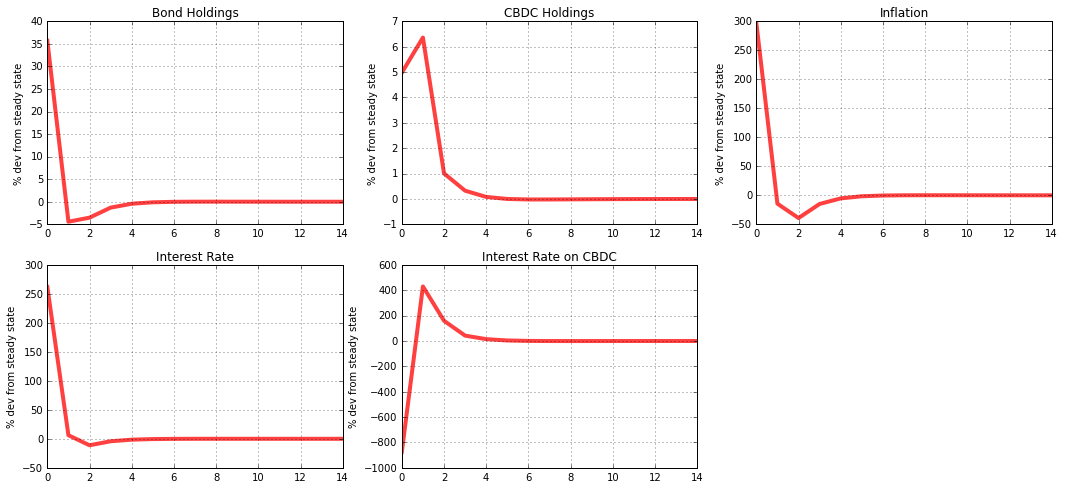

In [680]:
fig2 = plt.figure(figsize=(18,8))

# bond
ax = fig2.add_subplot(2,3,1)
ax.plot(model.irs['ea']['b'],'r',lw=4,alpha=0.75)
ax.set_title('Bond Holdings')
ax.set_ylabel('% dev from steady state')
# ax.set_ylim([-0.5, 8.5])
ax.grid()

# cash
ax = fig2.add_subplot(2,3,2)
ax.plot(model.irs['ea']['d'],'r',lw=4,alpha=0.75)
ax.set_title('CBDC Holdings')
ax.set_ylabel('% dev from steady state')
# ax.set_ylim([-1.5,0.5])
ax.grid()

# pi
ax = fig2.add_subplot(2,3,3)
ax.plot(model.irs['ea']['pi'],'r',lw=4,alpha=0.75)
ax.set_title('Inflation')
ax.set_ylabel('% dev from steady state')
# ax.set_ylim([-0.015,0.008])
ax.grid()

# r
ax = fig2.add_subplot(2,3,4)
ax.plot(model.irs['ea']['r'],'r',lw=4,alpha=0.75)
ax.set_title('Interest Rate')
ax.set_ylabel('% dev from steady state')
# ax.set_ylim([-0.015,0.008])
ax.grid()

# rd
ax = fig2.add_subplot(2,3,5)
ax.plot(model.irs['ea']['rd'],'r',lw=4,alpha=0.75)
ax.set_title('Interest Rate on CBDC')
ax.set_ylabel('% dev from steady state')
# ax.set_ylim([-0.015,0.008])
ax.grid()

# fig2.tight_layout()

In [681]:
fig2.savefig("cbdc_irf_2.png")

In [443]:
f2.savefig("theta_c.png")

In [720]:
# comparative statics with realistic values of cbdc interest rate spread
dshare = []
kshare = []
bshare = []
c_cs = []
d_cs = []

theta2_val = np.linspace(-0.03, 0.03, 70)

for i in theta2_val:
    theta2 = i

    pi_ss = 0.02
    rstar_ss = (1+pi_ss)/beta-1
    rd_ss = rstar_ss-theta2
    kappa_ss = ((1/beta-1+delta)/alpha)**(1/(alpha-1))
    n_ss = ((1-alpha)*kappa_ss**alpha)**(1/(omega-1))
    k_ss = kappa_ss*n_ss
    r_ss = rstar_ss
    y_ss = A*kappa_ss**alpha*n_ss
    I_ss = delta*k_ss

    def calc_c(c):
        return c*pi_ss-c*(rd_ss-pi_ss)/(1+pi_ss)+theta1*c**gamma*(c/(1+pi_ss))**zeta-(bbar*(rstar_ss-pi_ss)/(1+pi_ss)-kappa_ss**alpha*n_ss-delta*k_ss)
    c_ss = root(calc_c, 1, method = 'lm')['x'][0]
    d_ss = c_ss*(1+pi_ss)
    la_ss = (c_ss-n_ss**omega/omega)**(-sigma)/(1+theta1*gamma*(c_ss**(gamma-1))/d_ss**zeta) # MU of wealth
    
    d_rat = d_ss/(d_ss+k_ss+bbar)
    k_rat = k_ss/(d_ss+k_ss+bbar)
    b_rat = bbar/(d_ss+k_ss+bbar)
    dshare.append(d_rat)
    kshare.append(k_rat)
    bshare.append(b_rat)
    c_cs.append(c_ss)
    d_cs.append(d_ss)

C:\Users\darre\anaconda3\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in power


Text(0.5, 0, '$\\theta_2$: Spread Between $r_t$ and $r^d_t$ (bp)')

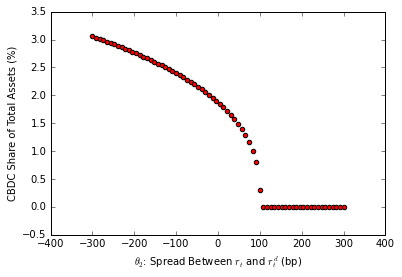

In [721]:
f3, ax3 = plt.subplots()

ax3.scatter([x*10000 for x in theta2_val], [x*100 for x in dshare], c= "r")
ax3.set_ylabel('CBDC Share of Total Assets (%)')
ax3.set_xlabel('$\\theta_2$: Spread Between $r_t$ and $r^d_t$ (bp)')

In [722]:
f3.savefig("dshare_spread.png")

Text(0.5, 0, '$\\theta_2$: Spread Between $r_t$ and $r^d_t$ (bp)')

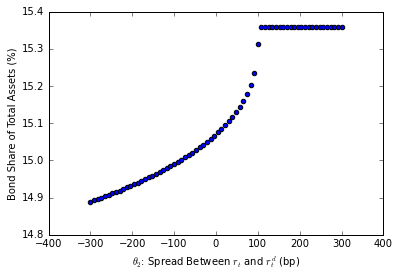

In [723]:
f5, ax5 = plt.subplots()

ax5.scatter([x*10000 for x in theta2_val], [x*100 for x in bshare])
ax5.set_ylabel('Bond Share of Total Assets (%)')
ax5.set_xlabel('$\\theta_2$: Spread Between $r_t$ and $r^d_t$ (bp)')

In [724]:
f5.savefig("bshare_spread.png")

Text(0.5, 0, '$\\Theta_2$: Spread Between $r_t$ and $r^d_t$ (bp)')

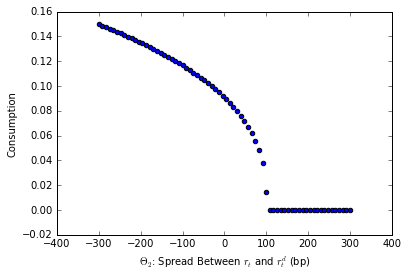

In [725]:
f6, ax6 = plt.subplots()

ax6.scatter([x*10000 for x in theta2_val], [x for x in c_cs])
ax6.set_ylabel('Consumption')
ax6.set_xlabel('$\Theta_2$: Spread Between $r_t$ and $r^d_t$ (bp)')

In [730]:
# 3d comparative statiscs
c_cs2 = []

theta2_val = np.linspace(-0.03, 0.03, 50)
inflation = np.linspace(-0.03, 0.03, 50)

for i in theta2_val:
    theta2 = i
    for j in inflation:
        pi = j

        rstar_ss = (1+pi)/beta-1
        rd_ss = rstar_ss-theta2
        kappa_ss = ((1/beta-1+delta)/alpha)**(1/(alpha-1))
        n_ss = ((1-alpha)*kappa_ss**alpha)**(1/(omega-1))
        k_ss = kappa_ss*n_ss
        r_ss = rstar_ss
        y_ss = A*kappa_ss**alpha*n_ss
        I_ss = delta*k_ss

        def calc_c(c):
            return c*pi-c*(rd_ss-pi)/(1+pi)+theta1*c**gamma*(c/(1+pi))**zeta-(bbar*(rstar_ss-pi)/(1+pi)-kappa_ss**alpha*n_ss-delta*k_ss)

        c_ss = root(calc_c, 0.5, method = "lm")['x'][0]
        d_ss = c_ss*(1+pi)
        # tb_ss = y_ss-I_ss-c_ss/(1+pi)+theta1*c_ss**gamma/d_ss**zeta/(1+pi)**(zeta)
        # tby_ss = tb_ss/y_ss
        # ca_ss = 1
        # cay_ss = ca_ss/y_ss
        # la_ss = (c_ss-n_ss**omega/omega)**(-sigma)/(1+theta1*gamma*(c_ss**(gamma-1))/d_ss**zeta) # MU of wealth
        c_cs2.append([i, j, c_ss])

C:\Users\darre\anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in power


In [731]:
from mpl_toolkits.mplot3d import Axes3D

In [732]:
import matplotlib.cm as cm

Text(0.5, 0, '$\\pi$ (%)')

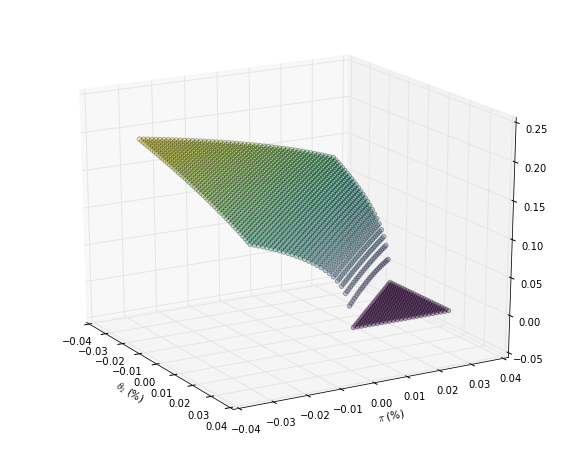

In [733]:
fig3d = plt.figure(figsize = (10, 8))
ax3d = fig3d.add_subplot(111, projection='3d')
ax3d.scatter([c_cs2[i][0] for i in range(0, len(c_cs2), 1)], [c_cs2[i][1] for i in range(0, len(c_cs2), 1)], [c_cs2[i][2] for i in range(0, len(c_cs2), 1)], c = [c_cs2[i][2] for i in range(0, len(c_cs2), 1)], alpha = 0.3, cmap = "viridis")
ax3d.view_init(elev=20, azim=-30)
ax3d.set_xlabel('$\\theta_2$ (%)')
ax3d.set_ylabel('$\\pi$ (%)')

In [414]:
fig3d.savefig("theta2_pi_c.png")

In [285]:


# define equilibrium equations
def equilibrium_equations(variables_forward,variables_current,parameters):
    
    # Parameters 
    p = parameters
    
    # Variables
    fwd = variables_forward
    cur = variables_current
    
    # MU of wealth
    e1 = (cur.c-cur.n**p.omega/p.omega)**(-p.sigma)/(1+p.theta1*p.gamma*cur.c**(p.gamma-1)/cur.d**p.zeta) - cur.la

    # Evolution of debt
    e2 = -fwd.b+(1+cur.r)*cur.b/(1+cur.pi)+cur.c+cur.I+p.phi/2*(fwd.k-cur.k)**2-cur.y-fwd.d+(1+cur.rd)*cur.d/(1+cur.pi)+p.theta1*cur.c**p.gamma/(cur.d**p.zeta) # cur.pi
    # e1 = -fwd.b+(1+r)*cur.b/(1+p.pi)+cur.c+cur.I+p.phi/2*(fwd.k-cur.k)**2-cur.y # cur.pi
    
    # output
    e3 = -cur.y+A*cur.k**p.alpha*cur.n**(1-p.alpha)

    # FOC w.r.t. n
    e4 = -cur.n**(p.omega-1)+(1-p.alpha)*cur.A*(cur.k/cur.n)**p.alpha

    # FOC w.r.t. bonds
    e5 = -cur.la + p.beta*(1+cur.r)/(1+fwd.pi)*fwd.la # fwd.pi
    # e5 = -cur.la + p.beta*(1+r_ss)/(1+p.pi)*fwd.la # fwd.pi

    # FOC w.r.t. capital
    e6 = -cur.la*(1+p.phi*(fwd.k-cur.k))+p.beta*fwd.la*(1-p.delta+p.alpha*cur.A*(fwd.k/fwd.n)**(p.alpha-1)+p.phi*(fwd.kfu-cur.k))

    # Country premium
    e7 = -fwd.r+rstar_ss+p.psi1*(np.exp(fwd.b-bbar)-1)

    # Investment
    e8 = -cur.I+fwd.k-(1-p.delta)*cur.k

    # Evolution of TFP
    e9 = -fwd.A + p.rho*(cur.A)

    # make kfu=kp
    e10 = -cur.kfu+fwd.k
    
    # foc for d
    e11 = -cur.la+p.beta*fwd.la*((1+cur.rd)/(1+fwd.pi)-p.zeta*p.theta1*(fwd.c**p.gamma)*(cur.d**(-p.zeta-1)))
    
    # definition of rd
    # e12 = -fwd.rd+cur.r-p.theta2
    # e12 = -fwd.rd + 0.95*cur.rd+0.5*(cur.pi-pi_ss) + 0.5*(cur.y-y_ss)
    e12 = -fwd.rd+cur.pi+0.75*(cur.pi-pi_ss)+0.25*(cur.y-y_ss)
    # e12 = -fwd.rd + 1.5*cur.pi+0.01
    
    # money supply
    e13 = -fwd.d + (1+p.mu)/(1+cur.pi)*cur.d
    
    return np.array([
        e1,
        e2,
        e3,
        e4,
        e5,
        e6,
        e7,
        e8,
        e9,
        e10,
        e11,
        e12,
        e13
    ])

parameter_vals = [alpha, delta, sigma, beta, bbar, theta1, gamma, zeta, theta2, omega, phi, psi1, rho, etat, mu] 
parameter_names = ['alpha','delta','sigma','beta','bbar','theta1','gamma','zeta','theta2','omega','phi','psi1','rho','etat','mu']
parameters = pd.Series(parameter_vals, index = parameter_names)

modelt = ls.model(equations = equilibrium_equations,
                 n_states=4,
                 var_names=['A', 'la', 'c', 'k', 'kfu', 'd', 'rd', 'n', 'b', 'y', 'I', 'r', 'pi'],
                 shock_names= ['ea'],
                 parameters = parameters)

modelt.set_ss(ss)

modelt.approximate_and_solve()
modelt.impulse(T=15,t0=0,shocks=[-0.01],percent=True, diff = True)

In [286]:
modelt.irs['ea'].head(10)

,ea,A,la,c,k,kfu,d,rd,n,b,y,I,r,pi
0,-1.0,-1.000000,0.000000,0.000000,0.000000,-1.832096,0.504466,110.166673,-1.290323,8.699472,-0.877419,-18.320965,0.0,-113.800421
1,0.0,-0.420000,-0.128902,-3.596399,-0.907756,0.008279,0.518210,-25.999492,-0.916751,5.052563,-0.913872,8.252597,0.0,-27.724781
2,0.0,-0.176400,-0.097594,-0.206141,0.400210,0.288047,0.173004,-6.697710,-0.062365,1.721082,0.085659,-0.721423,0.0,-14.564147
3,0.0,-0.074088,-0.056909,0.383893,0.447955,0.225099,0.057180,-1.205989,0.089365,0.560023,0.204114,-1.780607,0.0,-7.129381
4,0.0,-0.031117,-0.029726,0.333410,0.290573,0.132637,0.018346,0.081138,0.079827,0.175720,0.147266,-1.288784,0.0,-3.365079
5,0.0,-0.013069,-0.014616,0.203028,0.159518,0.069646,0.005631,0.249092,0.049002,0.052036,0.084367,-0.739205,0.0,-1.548978
6,0.0,-0.005489,-0.006919,0.108321,0.080710,0.034351,0.001606,0.183289,0.026243,0.013891,0.043672,-0.382880,0.0,-0.700201
7,0.0,-0.002305,-0.003191,0.053928,0.038915,0.016293,0.000397,0.105765,0.013094,0.002920,0.021357,-0.187305,0.0,-0.312243
8,0.0,-0.000968,-0.001445,0.025735,0.018180,0.007526,0.000065,0.054953,0.006257,0.000160,0.010073,-0.088362,0.0,-0.137786
9,0.0,-0.000407,-0.000645,0.011938,0.008307,0.003411,-0.000010,0.026934,0.002905,-0.000323,0.004634,-0.040659,0.0,-0.060301


In [1]:
fig4 = plt.figure(figsize=(18,8))

# bond
ax = fig4.add_subplot(2,3,1)
ax.plot(modelt.irs['ea']['b'],'r',lw=4,alpha=0.75)
ax.set_title('Bond Holdings')
ax.set_ylabel('% dev from steady state')
# ax.set_ylim([-0.5, 8.5])
ax.grid()

# cash
ax = fig4.add_subplot(2,3,2)
ax.plot(modelt.irs['ea']['d'],'r',lw=4,alpha=0.75)
ax.set_title('CBDC Holdings')
ax.set_ylabel('% dev from steady state')
# ax.set_ylim([-1.5,0.5])
ax.grid()

# pi
ax = fig4.add_subplot(2,3,3)
ax.plot(modelt.irs['ea']['pi'],'r',lw=4,alpha=0.75)
ax.set_title('Inflation')
ax.set_ylabel('% dev from steady state')
# ax.set_ylim([-0.015,0.008])
ax.grid()

# r
ax = fig4.add_subplot(2,3,4)
ax.plot(modelt.irs['ea']['r'],'r',lw=4,alpha=0.75)
ax.set_title('Interest Rate')
ax.set_ylabel('% dev from steady state')
# ax.set_ylim([-0.015,0.008])
ax.grid()

# rd
ax = fig4.add_subplot(2,3,5)
ax.plot(modelt.irs['ea']['rd'],'r',lw=4,alpha=0.75)
ax.set_title('Interest Rate on CBDC')
ax.set_ylabel('% dev from steady state')
# ax.set_ylim([-0.015,0.008])
ax.grid()

# fig2.tight_layout()

NameError: name 'plt' is not defined

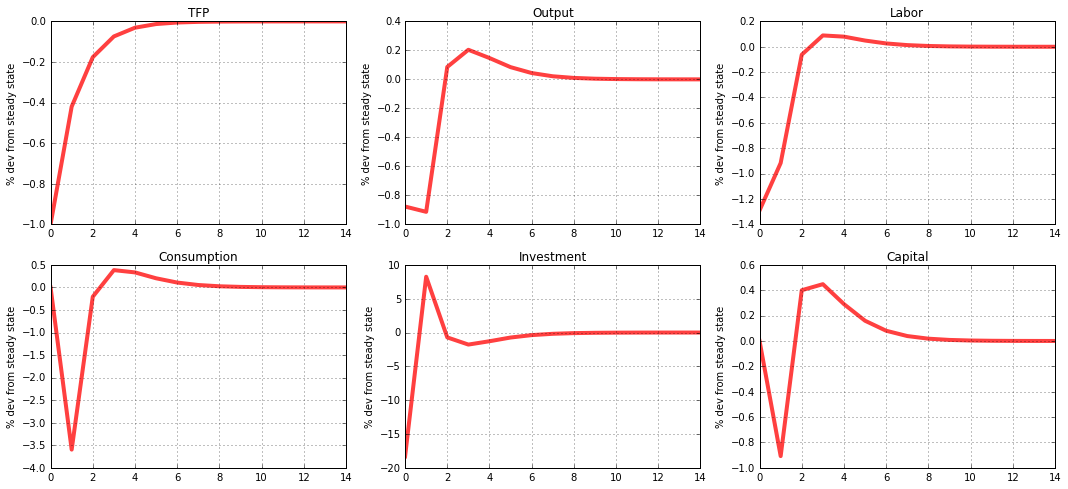

In [288]:
fig5 = plt.figure(figsize=(18,8))

# TFP
ax = fig5.add_subplot(2,3,1)
ax.plot(modelt.irs['ea']['A'],'r',lw=4,alpha=0.75)
ax.set_title('TFP')
ax.set_ylabel('% dev from steady state')
# ax.set_ylim([-1.5, 0.5])
ax.grid()

# output
ax = fig5.add_subplot(2,3,2)
ax.plot(modelt.irs['ea']['y'],'r',lw=4,alpha=0.75)
ax.set_title('Output')
ax.set_ylabel('% dev from steady state')
# ax.set_ylim([-2.6,0.5])
ax.grid()

# labor
ax = fig5.add_subplot(2,3,3)
ax.plot(modelt.irs['ea']['n'],'r',lw=4,alpha=0.75)
ax.set_title('Labor')
ax.set_ylabel('% dev from steady state')
# ax.set_ylim([-1.6,0.5])
ax.grid()

# consumption
ax = fig5.add_subplot(2,3,4)
ax.plot(modelt.irs['ea']['c'],'r',lw=4,alpha=0.75)
ax.set_title('Consumption')
ax.set_ylabel('% dev from steady state')
# ax.set_ylim([-4.2,0.5])
ax.grid()

# investment
ax = fig5.add_subplot(2,3,5)
ax.plot(modelt.irs['ea']['I'],'r',lw=4,alpha=0.75)
ax.set_title('Investment')
ax.set_ylabel('% dev from steady state')
# ax.set_ylim([-4.0,2.0])
ax.grid()

# capital
ax = fig5.add_subplot(2,3,6)
ax.plot(modelt.irs['ea']['k'],'r',lw=4,alpha=0.75)
ax.set_title('Capital')
ax.set_ylabel('% dev from steady state')
# ax.set_ylim([-9.5,1.0])
ax.grid()

# fig.tight_layout()